# Introduction

## Project Overview
The AutoDiff project aims to implement a class for mathematical functions that enables operations like evaluation, arithmetic operations, concatenation, and differentiation in an intuitive manner. This project focuses on providing a user-friendly interface for these operations without relying on external libraries for automatic differentiation or symbolic computation.

**Objectives**
* To provide a foundational class that supports a wide range of mathematical functions.
* To enable straightforward arithmetic operations between functions.
* To support the differentiation and evaluation of functions with ease.
* To offer additional functionalities such as plotting, handling multi-dimensional inputs, and more.

# AutoDiffFunction - Class Definition

The core of the AutoDiff project is encapsulated in the `AutoDiffFunction` class, defined within`autodiff.py`, in the project repository.  
The `AutoDiffFunction` class is a cornerstone of the project designed to facilitate automatic differentiation. The class is initialized with two primary parameters: a function and its derivative, allowing for the evaluation and differentiation of mathematical expressions. It supports vector-valued functions through the `is_vector_valued` flag, enabling a wide range of applications from scalar functions to systems of equations.

Key functionalities include:


*   **Evaluation**: Method `evaluate` computes the function's value at given
points, accommodating both scalar and vector-valued functions.List item
*   **Differentiation**: Method `differentiate` calculates derivatives or Jacobians, using a numerical approach if an analytical derivative is not provided.
*   **Arithmetic Operations**: The class overloads arithmetic operators to combine `AutoDiffFunction` instances, facilitating complex expressions.
*   **Function Composition**: Incorporates the chain rule for derivatives through function composition, enhancing the class's analytical capabilities.


*   **Extended Mathematical Support**: Includes methods for exponential, sine, and cosine functions, directly extending the class's versatility.
*   **Plotting**: A method to plot the function over a specified range, aiding in visualization and analysis.

The method used for differentiation in the `AutoDiffFunction` class is numerical differentiation, specifically utilizing the *central difference* formula for its calculations. This approach approximates the derivative of a function at a point by evaluating the function at slightly shifted points around the target and dividing the difference by the shift. Mathematically, The central difference formula for approximating the derivative of a function $f$ at a point $x$ with a small step $h$ is:

$$
f'(x) \approx \frac{f(x + h) - f(x - h)}{2h}
$$
 

This foundation sets the stage for advanced operations, including handling piecewise functions and implementing polynomial functions, showcasing the class's flexibility and power in tackling automatic differentiation challenges.





In [15]:
import numpy as np
import matplotlib.pyplot as plt
import functools

class AutoDiffFunction:
    def __init__(self, function, derivative=None, is_vector_valued=False):
        self.function = np.vectorize(function)
        self.derivative = derivative if derivative is not None else self._numerical_derivative
        self.is_vector_valued = is_vector_valued


    def evaluate(self, *args):
        if self.is_vector_valued:
            # For vector-valued functions, ensure we return a NumPy array
            return np.array(self.function(*args))
        else:
            return self.function(*args)

    def differentiate(self, *args, h=1e-5):
        if self.is_vector_valued:
            jacobian = []
            for i in range(len(self.function(*args))):
                partial_derivatives = []
                for j in range(len(args)):
                    def wrapped_func(*wrapped_args):
                        return self.function(*wrapped_args)[i]
                    partial_derivative = self._partial_derivative(wrapped_func, list(args), j, h)
                    partial_derivatives.append(partial_derivative)
                jacobian.append(partial_derivatives)
            return np.array(jacobian)
        else:
            if len(args) == 1:
                return np.vectorize(self._numerical_derivative)(args[0], h)
            else:
                return np.array([self._partial_derivative(self.function, list(args), i, h) for i in range(len(args))])


    def _numerical_derivative(self, x, h=1e-6):
        return (self.function(x + h) - self.function(x - h)) / (2 * h)


    def _partial_derivative(self, f, vars, idx, h):
        vars_plus_h = vars.copy()
        vars_minus_h = vars.copy()
        vars_plus_h[idx] += h
        vars_minus_h[idx] -= h
        return (f(*vars_plus_h) - f(*vars_minus_h)) / (2 * h)

    @functools.lru_cache(maxsize=128)
    def evaluate_cached(self, x):
        return self.evaluate(x)

    # Arithmetic operations
    def __add__(self, other):
        new_function = lambda x: self.evaluate(x) + other.evaluate(x)
        new_derivative = lambda x: self.differentiate(x) + other.differentiate(x)
        return AutoDiffFunction(new_function, new_derivative)

    def __mul__(self, other):
        new_function = lambda x: self.evaluate(x) * other.evaluate(x)
        new_derivative = lambda x: (self.differentiate(x) * other.evaluate(x) +
                                    self.evaluate(x) * other.differentiate(x))
        return AutoDiffFunction(new_function, new_derivative)

    def __truediv__(self, other):
        new_function = lambda x: self.evaluate(x) / other.evaluate(x)
        new_derivative = lambda x: (self.differentiate(x) * other.evaluate(x) -
                                    self.evaluate(x) * other.differentiate(x)) / other.evaluate(x)**2
        return AutoDiffFunction(new_function, new_derivative)

    # Concatenation and chain rule
    def compose(self, other):
        new_function = lambda x: self.evaluate(other.evaluate(x))
        new_derivative = lambda x: self.differentiate(other.evaluate(x)) * other.differentiate(x)
        return AutoDiffFunction(new_function, new_derivative)

    # Adding standard mathematical functions
    @staticmethod
    def polynomial(coeffs):
        """Creates a polynomial function with given coefficients."""
        def poly_function(x):
            return np.polyval(coeffs, x)

        def poly_derivative(x):
            # Create derivative coefficients
            d_coeffs = np.polyder(coeffs)
            return np.polyval(d_coeffs, x)

        return AutoDiffFunction(poly_function, poly_derivative)

    def exp(self):
        """Exponential function."""
        new_function = lambda x: np.exp(self.function(x))
        new_derivative = lambda x: np.exp(self.function(x)) * self.derivative(x)
        return AutoDiffFunction(new_function, new_derivative)

    def sin(self):
        """Sine function."""
        new_function = lambda x: np.sin(self.function(x))
        new_derivative = lambda x: np.cos(self.function(x)) * self.derivative(x)
        return AutoDiffFunction(new_function, new_derivative)

    def cos(self):
        """Cosine function."""
        new_function = lambda x: np.cos(self.function(x))
        new_derivative = lambda x: -np.sin(self.function(x)) * self.derivative(x)
        return AutoDiffFunction(new_function, new_derivative)


    def plot(self, x_range, num_points=100, plot_position=None, title=None):
        x_values = np.linspace(*x_range, num_points)
        y_values = self.evaluate(x_values)
        if plot_position:  # If subplot positioning is specified
            plt.subplot(*plot_position)
        plt.plot(x_values, y_values, label=title)
        plt.title(title if title else 'Function Plot')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.grid(True)
        if plot_position:  # Only show legend and tight layout for subplots
            plt.legend()
            plt.tight_layout()


    # Advanced operation: Piecewise function
    def piecewise(*conditions_and_funcs):
        """Creates a piecewise function from a list of (condition, function) tuples."""
        def piecewise_function(x):
            for condition, func in conditions_and_funcs:
                if condition(x):
                    return func.evaluate(x)
            return None  # Default case if no condition is met

        def piecewise_derivative(x):
            for condition, func in conditions_and_funcs:
                if condition(x):
                    return func.derivative(x)
            return None  # Default case if no condition is met

        return AutoDiffFunction(piecewise_function, piecewise_derivative)



    # Flexible argument method: Sum of functions
    @staticmethod
    def sum(*functions):
        """Calculates the sum of multiple AutoDiffFunction instances."""
        def sum_function(x):
            return np.sum([f.evaluate(x) for f in functions])

        def sum_derivative(x):
            return np.sum([f.differentiate(x) for f in functions])

        return AutoDiffFunction(sum_function, sum_derivative)

    ## Advanced Functionality: Sum and Product
    @staticmethod
    def product(*functions):
        """Calculates the product of multiple AutoDiffFunction instances."""
        def product_function(x):
            result = float(functions[0].evaluate(x))
            for f in functions[1:]:
                result *= f.evaluate(x)
            return result

        def product_derivative(x):
            sum_deriv = np.zeros_like(x)
            for i, fi in enumerate(functions):
                prod_deriv = fi.differentiate(x)
                for fj in functions:
                    if fi != fj:
                        prod_deriv *= fj.evaluate(x)
                sum_deriv += prod_deriv
            return sum_deriv

        return AutoDiffFunction(product_function, product_derivative)


# Usage Examples

This section showcases practical applications of the AutoDiffFunction class to demonstrate its capabilities. All the examples are provided in `examples.py` in the project repository and cover a range of scenarios from basic usage to more complex applications involving multi-dimensional and vector-valued functions.

## Basic Function Evaluation and Differentiation
This section provides clear examples demonstrating how to define functions using the `AutoDiffFunction` class, evaluate these functions at specific points, and differentiate them. A simple quadratic function serves as the initial example, showcasing the class's ability to compute both the function value and its derivative with minimal user input. This foundational example paves the way for understanding more complex operations and functionalities of the class.

In [2]:
# Define a simple quadratic function f(x) = x^2
f = AutoDiffFunction(lambda x: x**2, lambda x: 2*x)

# Evaluate the function and its derivative at x = 2
print("f(2) =", f.evaluate(2))
print("f'(2) =", f.differentiate(2))

f(2) = 4
f'(2) = 4.000000000026205


## Arithmetic Operations between Functions
This section illustrates the capability of the `AutoDiffFunction` class to perform arithmetic operations directly between functions. By defining two functions, such as a quadratic function and a sine function, the examples demonstrate how to sum and multiply these functions to create new `AutoDiffFunction` instances. These operations showcase the class's ability to handle complex expressions naturally, reinforcing its utility in mathematical and engineering applications where such operations are commonplace.

In [3]:
# Define another function g(y) = sin(y)
g = AutoDiffFunction(np.sin, lambda y : np.cos(y))

# Perform arithmetic operations; here, f(y) = y**2
sum_func = f + g
prod_func = f * g

# Evaluate the new functions and their derivatives at x = pi/4
x_val = np.pi / 4
print("Sum function at x = pi/4:", sum_func.evaluate(x_val))
print("Product function at x = pi/4:", prod_func.evaluate(x_val))


Sum function at x = pi/4: 1.3239570562546323
Product function at x = pi/4: 0.4361790124774299


## Plotting Functionality
This section showcases the `AutoDiffFunction` class's plotting capabilities, demonstrating how functions and their arithmetic combinations can be visually represented. Through a series of plots within a 2x2 grid, it visualizes the quadratic function, the sine function, and their sum and product. This functionality is essential for analyzing the behavior of functions, facilitating a deeper understanding of their characteristics over a specified domain. It highlights the class's utility in exploratory data analysis, where visual insights into functions are invaluable.

In [4]:
# Prepare the figure for a 2x2 grid of plots
plt.figure(figsize=(10, 8))

# Plot each function in a subplot
f.plot(x_range=[-np.pi, np.pi], plot_position=(2, 2, 1), title='f(x) = x^2')
g.plot(x_range=[-np.pi, np.pi], plot_position=(2, 2, 2), title='g(x) = sin(x)')
sum_func.plot(x_range=[-np.pi, np.pi], plot_position=(2, 2, 3), title='Sum: f(x) + g(x)')
prod_func.plot(x_range=[-np.pi, np.pi], plot_position=(2, 2, 4), title='Product: f(x) * g(x)')

plt.show()

## Function Concatenation and Chain Rule
This section delves into the advanced feature of the `AutoDiffFunction` class, which allows for function concatenation and the application of the chain rule for differentiation. Through examples, it demonstrates how to create composite functions by concatenating existing ones and how the class automatically applies the chain rule to compute derivatives of these composite functions. This functionality is pivotal for constructing complex mathematical models and efficiently obtaining their derivatives, underscoring the class's adaptability and power in mathematical computation.

In [5]:
# Compose functions f and g: h(x) = f(g(x)) = (sin(x))^2
h = f.compose(g)

# Evaluate and differentiate the composite function at x = pi/4
print("h(pi/4) =", h.evaluate(x_val))
print("h'(pi/4) =", h.differentiate(x_val))

h(pi/4) = 0.4999999999999999
h'(pi/4) = 0.9999999999288355


In [6]:
## Composite Functions with Chain Rule
# Example 1: Define the composite function C(x) = exp(sin(x)^2))
sin_func = AutoDiffFunction(np.sin, np.cos)
quad_func = AutoDiffFunction(lambda x: x**2, lambda x: 2*x)
exp_func = AutoDiffFunction(np.exp, np.exp)
composite = exp_func.compose(quad_func).compose(sin_func)

# Evaluate and differentiate the composite function at x = pi/4
x_val_trig = np.pi/4
print("C(pi/4) =", composite.evaluate(x_val_trig))
print("C'(pi/4) =", composite.differentiate(x_val_trig))


C(pi/4) = 1.648721270700128
C'(pi/4) = 1.648721270608444


In [7]:
# Example 2: Function - C(x) = ln(1 + e^x)
add_func = AutoDiffFunction(lambda x: 1 + x)
ln_func = AutoDiffFunction(lambda x: np.log(x))

composite_func = ln_func.compose(add_func.compose(exp_func))

# Evaluate and differentiate the composite function at x = 0
x_val = 0
print("C(pi/4) =", composite_func.evaluate(x_val))
print("C'(pi/4) =", composite_func.differentiate(x_val))

C(pi/4) = 0.6931471805599453
C'(pi/4) = 0.4999999999921733


## Univariate, Multivariate and Vector-Valued Functions
This section emphasizes the `AutoDiffFunction` class's versatility in handling univariate, multivariate, and vector-valued functions. It demonstrates the class's capability to evaluate and differentiate:

* **Univariate functions**, which involve a single variable,
* **Multivariate functions**, where functions depend on more than one variable, and
* **Vector-valued functions**, which return vectors as outputs.  

These examples illustrate the broad applicability of the class across different mathematical domains, showcasing its utility in dealing with a wide array of computational problems.

In [8]:
## Univariate Function
f = AutoDiffFunction(lambda x: x**2 + 2*x + 1)
print("f(3) =", f.evaluate(3))  # Evaluate at x=3
print("f'(3) =", f.differentiate(3))  # Differentiate at x=3

f(3) = 16
f'(3) = 8.00000000005241


In [9]:
## Multivariate Function
g = AutoDiffFunction(lambda x, y: x**2 + y**2)
print("g(3, 4) =", g.evaluate(3, 4))  # Evaluate at (x=3, y=4)
print("∇g(3, 4) =", g.differentiate(3, 4))  # Differentiate at (x=3, y=4)

g(3, 4) = 25
∇g(3, 4) = [6. 8.]


In [10]:
## Vector-valued Function
h = AutoDiffFunction(lambda x: [x**2, x**3], is_vector_valued=True)
print("h(2) =", h.evaluate(2))  # Evaluate at x=2
print("Jacobian of h at x=2 =\n", h.differentiate(2))  # Differentiate at x=2

h(2) = [4 8]
Jacobian of h at x=2 =
 [[ 4.]
 [12.]]


In [11]:
# Define the multivariate, vector-valued function F(x, y) = [x^2 + y^2, 2*x*y]
F = AutoDiffFunction(lambda x, y: [x**2 + y**2, 2*x*y],
                     is_vector_valued=True)

# Evaluate the function at a point (x=1, y=2)
evaluation = F.evaluate(1, 2)
print(f'F(1, 2) = {evaluation}')

# Differentiate the function at the same point
differentiation = F.differentiate(1, 2)
print(f'Jacobian of F at (1, 2) = \n{differentiation}')

F(1, 2) = [5 4]
Jacobian of F at (1, 2) = 
[[2. 4.]
 [4. 2.]]


## Sum and Product of Functions
This section introduces methods within the `AutoDiffFunction` class for calculating the sum and product of multiple functions. It demonstrates the class's ability to perform these operations, returning new `AutoDiffFunction` instances representing the aggregated functions. This functionality is crucial for complex mathematical expressions where sums and products of different functions are needed, showcasing the class's capability to simplify and automate such operations for ease of use and increased efficiency in computational tasks.

In [17]:
# Define a sum and product of f and g
f = AutoDiffFunction(lambda x: x**2, lambda x: 2*x)
g = AutoDiffFunction(np.sin, lambda y : np.cos(y))

# sum = x**2 + sin(x)
sum_of_funcs = AutoDiffFunction.sum(f, g)
# product = x**2 * sin(x)
prod_of_funcs = AutoDiffFunction.product(f, g)

# Evaluate and differentiate the sum and product at x = pi/4
x_val = np.pi/4
print("Sum of f and g at pi/4:", sum_of_funcs.evaluate(x_val))
print("Product of f and g at pi/4:", prod_of_funcs.evaluate(x_val))


Sum of f and g at pi/4: 1.3239570562546323
Product of f and g at pi/4: 0.4361790124774299


## Piecewise Functionality
This section expands the `AutoDiffFunction` class's capabilities by introducing support for piecewise functions. It demonstrates how to construct a function that behaves differently across various intervals of its domain, effectively broadening the class's applicability to a wider range of mathematical problems. This functionality is particularly useful for modeling scenarios that require different expressions in different regions, offering a powerful tool for handling complex, conditional mathematical models.

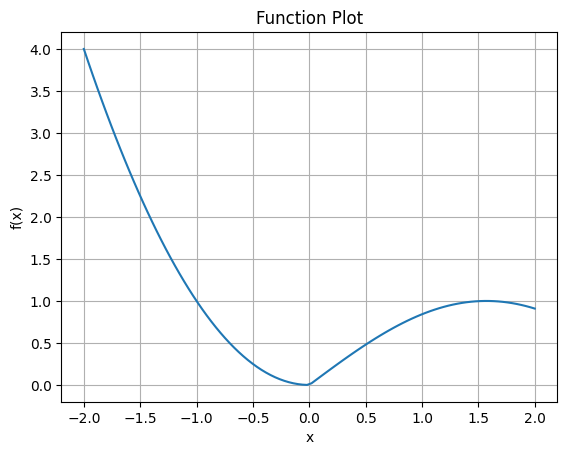

In [62]:
# Define a piecewise function that behaves differently on intervals
PW = AutoDiffFunction.piecewise(
    (lambda x: x < 0, AutoDiffFunction(lambda x: x**2)),
    (lambda x: x >= 0, AutoDiffFunction(np.sin))
)

PW.plot([-2, 2])

In [63]:
# Evaluate the piecewise function at x = -1 and x = 1
print("PW(-1) =", PW.evaluate(-1))
print("PW(1) =", PW.evaluate(1))
print("PW'(-1) =", PW.differentiate(-1))
print("PW'(1) =", PW.differentiate(1))

PW(-1) = 1
PW(1) = 0.8414709848078965
PW'(-1) = -2.000000000002
PW'(1) = 0.5403023058569989


## Polynomial Functions
This section introduces the functionality for defining and working with polynomial functions within the `AutoDiffFunction` class. By utilizing a method specifically designed for creating polynomial expressions based on given coefficients, users can easily instantiate polynomial functions and compute their derivatives. This feature simplifies the process of working with polynomials, highlighting the class's capacity to accommodate a broad spectrum of mathematical functions and further demonstrating its versatility and utility in computational mathematics.

In [64]:
# Define a polynomial function P(x) = 3x^3 - 2x^2 + x - 5
coeffs = [3, -2, 1, -5]
p = AutoDiffFunction.polynomial(coeffs)

# Evaluate and differentiate the polynomial at x = 1
x_val_poly = 1
print("P(1) =", p.evaluate(x_val_poly))
print("P'(1) =", p.differentiate(x_val_poly))

P(1) = -3
P'(1) = 6.000000000327964


## Trigonometric Identities
This part of the documentation highlights how the `AutoDiffFunction` class can be utilized to model and differentiate functions involving trigonometric identities. It showcases the flexibility of the class in handling trigonometric functions like sine and cosine, both individually and as part of more complex expressions. By demonstrating the evaluation and differentiation of functions that embody trigonometric identities, this section underscores the class's effectiveness in addressing a wide range of mathematical problems, reinforcing its value in scientific computing and engineering applications.

In [65]:
# Example : Define the trigonometric function T(x) = sin(x)cos(x)
sin_func = AutoDiffFunction(np.sin, np.cos)
cos_func = AutoDiffFunction(np.cos, lambda x: -np.sin(x))
T = sin_func * cos_func

# Evaluate and differentiate the function using the trigonometric identity at x = pi/4
x_val_trig = np.pi / 4
print("T(pi/4) =", T.evaluate(x_val_trig))
print("T'(pi/4) =", T.differentiate(x_val_trig))


T(pi/4) = 0.5
T'(pi/4) = 0.0


In [67]:
# Example 2: Define the trigonometric function T(x) = (sin(x))^2 + cos(x)^2
square_fn = AutoDiffFunction(lambda x: x**2)
t1 = square_fn.compose(sin_func)
t2 = square_fn.compose(cos_func)

T2 = t1 + t2
print("T(p), where p ∈ (0, np.pi/4, np.pi/2, np.pi)")
print(T2.evaluate([0, np.pi/4, np.pi/2, np.pi]))
print("T'(p), where p ∈ (0, np.pi/4, np.pi/2, np.pi)")
print(T2.differentiate([0, np.pi/4, np.pi/2, np.pi]))

T(p), where p ∈ (0, np.pi/4, np.pi/2, np.pi)
[1. 1. 1. 1.]
T'(p), where p ∈ (0, np.pi/4, np.pi/2, np.pi)
[0. 0. 0. 0.]


# Conclusion

The current implementation of the `AutoDiffFunction` relies on numerical differentiation, offering a practical approach to automatic differentiation across a variety of functions. Looking ahead, integrating the reverse mode of automatic differentiation [[1]](https://epubs.siam.org/doi/epdf/10.1137/080743627) could vastly expand its applicability, especially for functions with many independent variables. This advancement would harness computational graphs, enhancing efficiency and making the tool even more powerful for complex computational tasks.